# Data

**Fundamental Energy Data (Provided)**

*Recent and Historic Energy Statistics*

* crude_oil_production_deseasonalized.csv
    
    * Residual from detrended and de-seasonalized oil production data 
    

* petroleum_consumption_deseasonalized.csv
    
    * Residual from detrended and de-seasonalized oil consumption data


<br>

**Market Data**

*Futures Curves (From Refinitiv)*

* wti_futures_curves_diffs.csv
    * Contains spot prices, % difference of each consecutive futures contract from spot, and 1-month Implied Volatility (%) on the front-month futures contract (from volatility smile in wti_continuous_options_moneyness.csv)


*Energy Sector Stocks and Commodities (HLOC) (Provided)*

* wti_price.csv
    * Price series of WTI Crude Oil

* log_geom_diff_wti_price.csv 
    * Difference in logs of WTI price 
    
* SPY.csv
    * Price series of S&P 500 index

* SPY_log_geom_diff.csv
    * Difference in logs of SPY price

* IYE.csv
    * Price series of IYE (U.S. Energy Companies) Index
* IYE_log_geom_diff.csv
    * Difference in logs of IYE price


In [520]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

#

## Import Data

In [521]:
# Import Data

# Consumption
petroleum_consumption_deseasonalized = pd.read_csv(r"data\\cleaned_data\\consumption_production\\petroleum_consumption_deseasonalized.csv")
# set index to datetime
petroleum_consumption_deseasonalized.set_index("Date", inplace=True)
petroleum_consumption_deseasonalized.index.name = "Date"
petroleum_consumption_deseasonalized.index = pd.to_datetime(petroleum_consumption_deseasonalized.index)
petroleum_consumption_deseasonalized = petroleum_consumption_deseasonalized.iloc[:, 0]


#Production
crude_oil_production_deseasonalized = pd.read_csv(r"data\\cleaned_data\\consumption_production\\crude_oil_production_deseasonalized.csv")
# set index to datetime
crude_oil_production_deseasonalized.set_index("Date", inplace=True)
crude_oil_production_deseasonalized.index.name = "Date"
crude_oil_production_deseasonalized.index = pd.to_datetime(crude_oil_production_deseasonalized.index)
crude_oil_production_deseasonalized = crude_oil_production_deseasonalized.iloc[:, 0]


# Futures
wti_futures_curves_diffs = pd.read_csv(r"data\cleaned_data\futures\wti_futures_diffs.csv")
wti_futures_curves_diffs.set_index("Unnamed: 0", inplace=True)
wti_futures_curves_diffs.index.name = "Date"
wti_futures_curves_diffs.index = pd.to_datetime(wti_futures_curves_diffs.index)


# Stocks and Commodity Prices
wti_price = pd.read_csv(r"data\\cleaned_data\\prices\\wti_price.csv")
log_geom_diff_wti_price = pd.read_csv(r"data\\cleaned_data\\prices\\log_geom_diff_wti_price.csv")

log_geom_diff_spy = pd.read_csv(r"data\\cleaned_data\\prices\\SPY_log_geom_diff.csv")
log_geom_diff_spy.set_index('Date-Time', inplace=True)
log_geom_diff_spy.index = pd.to_datetime(log_geom_diff_spy.index)

log_geom_diff_iye = pd.read_csv(r"data\\cleaned_data\\prices\\IYE_log_geom_diff.csv")
log_geom_diff_iye.set_index('Date', inplace=True)
log_geom_diff_iye.index = pd.to_datetime(log_geom_diff_iye.index, utc=True)



# Model

$$
\sigma_m = \alpha + \beta' X_m + \epsilon_m
$$

where $m$ represents the current month and $\beta, X$ are length 9 with:

1. **$X_1$: One Month Lagged Volatility in WTI Price** - This variable captures the volatility of oil prices from the previous month, based on the assumption that past volatility can influence future volatility through mechanisms like volatility clustering.

2. **$X_2$: One Month Lagged Change in Spot Price** - The month-over-month percentage log-geometric change in the spot price of WTI Crude oil. This variable helps to understand how recent price movements might influence the market's volatility expectations.

3. **$X_3$: Lagged Moving Average of Production** - Calculated as the moving average (MA) of oil production over a specified number of periods (p). This indicator can reflect supply-side trends influencing market volatility.

4. **$X_4$: Lagged Moving Average of Consumption** - Similar to $X_3$, but for oil consumption, indicating demand-side influences on market volatility. The moving average is calculated over the same number of periods (p) for consistency.

5. **$X_5$: Lagged % Difference Between Spot and Front Month Contract** - This variable measures the short-term market sentiment and immediate supply and demand dynamics by comparing the spot price to the price of the nearest futures contract.

6. **$X_6$: Lagged Average % Difference Between Spot and the Next 11 Contracts** - Reflects medium-term market expectations beyond the immediate future by averaging the price differences between the spot and the next 11 futures contracts.

7. **$X_7$: Lagged Average % Difference Between Spot and Contracts [13: ]** - Averages the percentage difference between the spot price and long-term futures contracts (from the 13th contract onwards), indicating long-term market expectations.

8. **$X_8$: 1 Month Lagged Volatility in S&P 500** - Standard deviation in the prior month's observed SPY log-geometric differences.

9. **$X_9$: 1 Month Lagged Volatility in IYE (iShares U.S. Energy ETF)** - Standard deviation in the prior month's observed IYE log-geometric differences.

10. **$X_{10}$: Lagged 1 Month Average Implied Volatility (IV) on Front Month WTI Futures** - Average over Implied Volatility calculated for 1 month-to-expiry options on the front month WTI Crude future with moneyness from 80% - 120% in increments of 5%.


In [522]:
# Get monthly volatility in WTI Oil Price

log_geom_diff_wti_price.set_index('Date_Time', inplace=True)
log_geom_diff_wti_price.index = pd.to_datetime(log_geom_diff_wti_price.index)



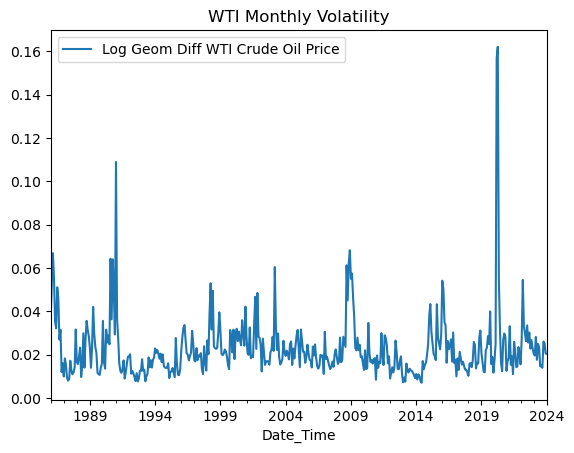

In [523]:
WTI_monthly_vol = log_geom_diff_wti_price.groupby(pd.Grouper(freq='M')).std()
WTI_monthly_vol.rename(columns={'WTI_Price': 'WTI_Monthly_Vol'}, inplace=True)

WTI_monthly_vol.plot()
plt.title('WTI Monthly Volatility')
plt.show()


In [524]:
# # Define vars

# # Model

# $$
# \sigma_m = \alpha + \beta' X_m + \epsilon_m
# $$

# where $m$ represents the current month and $\beta, X$ are length 9 with:

# 1. **$X_1$: One Month Lagged Volatility in WTI Price** - This variable captures the volatility of oil prices from the previous month, based on the assumption that past volatility can influence future volatility through mechanisms like volatility clustering.

# 2. **$X_2$: One Month Lagged Change in Spot Price** - The month-over-month percentage log-geometric change in the spot price of WTI Crude oil. This variable helps to understand how recent price movements might influence the market's volatility expectations.

# 3. **$X_3$: Moving Average of Production** - Calculated as the moving average (MA) of oil production over a specified number of periods (p). This indicator can reflect supply-side trends influencing market volatility.

# 4. **$X_4$: Moving Average of Consumption** - Similar to $X_3, but for oil consumption, indicating demand-side influences on market volatility. The moving average is calculated over the same number of periods (p) for consistency.

# 5. **$X_5$: % Difference Between Spot and Front Month Contract** - This variable measures the short-term market sentiment and immediate supply and demand dynamics by comparing the spot price to the price of the nearest futures contract.

# 6. **$X_6$: Average % Difference Between Spot and the Next 11 Contracts** - Reflects medium-term market expectations beyond the immediate future by averaging the price differences between the spot and the next 11 futures contracts.

# 7. **$X_7$: Average % Difference Between Spot and Contracts [13: ]** - Averages the percentage difference between the spot price and long-term futures contracts (from the 13th contract onwards), indicating long-term market expectations.

# 8. **$X_8$: 1 Month Lagged Volatility in S&P 500** - Incorporates broader market volatility into the model, as financial markets can be interconnected, and overall market volatility can influence commodity prices, including oil.

# 9. **$X_9$: 1 Month Lagged Volatility in IYE (iShares U.S. Energy ETF)** - This variable specifically captures the volatility in the energy sector, potentially offering insights into sector-specific factors affecting oil price volatility.

# 10. **$X_{10}$: 1 Month Average Implied Volatility (IV) from Options on Front Month WTI Futures** - This is a direct measure of the market's expectation of future volatility, derived from the options market.


# Create X and Y dfs
Y = WTI_monthly_vol.copy()
X = pd.DataFrame()

# X1: One Month Lagged Volatility in WTI Price
X['WTI_Lagged_Vol'] = WTI_monthly_vol['Log Geom Diff WTI Crude Oil Price'].shift(1)

# X2: One Month Lagged Change in Spot Price
# Get log geom diff of spot price, sum changes per month to get monthly log geom diff in stock price
monthly_log_geom_diff_wti_spot = log_geom_diff_wti_price.groupby(pd.Grouper(freq='M')).sum()
monthly_log_geom_diff_wti_spot.rename(columns={'Log Geom Diff WTI Crude Oil Price': 'Monthly_Log_Geom_Diff_WTI_Spot'}, inplace=True)
# Get 1 month lag
X['WTI_Lagged_Spot_Change'] = monthly_log_geom_diff_wti_spot['Monthly_Log_Geom_Diff_WTI_Spot'].shift(1)

# X3: Lagged Moving Average of Production
p = 12
crude_ma = crude_oil_production_deseasonalized.rolling(window=p).mean()
# subset crude MA down to monthly frequency (end of month)
crude_ma = crude_ma.groupby(pd.Grouper(freq='M')).last()
X['Crude_Oil_Production_MA'] = crude_ma.shift(1)

# X4: Lagged Moving Average of Consumption
petro_cons_ma = petroleum_consumption_deseasonalized.rolling(window=p).mean()
# subset consumption MA down to monthly frequency (end of month)
petro_cons_ma = petro_cons_ma.groupby(pd.Grouper(freq='M')).last()
X['Petroleum_Consumption_MA'] = petro_cons_ma.shift(1)


# X5: % Lagged Difference Between Spot and Front Month Contract
X['Spot_Front_Month_Diff_Lagged'] = wti_futures_curves_diffs['contract1 % diff from spot'].shift(1)

# X6: Lagged Average % Difference Between Spot and the Next 11 Contracts
# get the average of the next 11 contracts
avg_med = wti_futures_curves_diffs.iloc[:, 3:14].mean(axis=1)
X['Spot_Next_11_Contracts_Avg_Lagged'] = avg_med.shift(1)

# X7: Average % Difference Between Spot and Contracts [13: ]
# get the average of the contracts from 13 onwards
avg_long = wti_futures_curves_diffs.iloc[:, 14:].mean(axis=1)
X['Spot_Long_Contracts_Avg_Lagged'] = avg_long.shift(1)

# X8: 1 Month Lagged Volatility in S&P 500
# create get std of log geom changes per month in spy
monthly_vol_spy = log_geom_diff_spy.groupby(pd.Grouper(freq='M')).std()
monthly_vol_spy.rename(columns={'Close': 'Monthly_Vol_S&P_500'}, inplace=True)
X['SPY_Lagged_Vol'] = monthly_vol_spy['Monthly_Vol_S&P_500'].shift(1)


# X9: 1 Month Lagged Volatility in IYE
# create get std of log geom changes per month in iye
monthly_vol_iye = log_geom_diff_iye.groupby(pd.Grouper(freq='M')).std()
monthly_vol_iye.index = monthly_vol_iye.index.tz_localize(None)
X['IYE_Lagged_Vol'] = monthly_vol_iye.shift(1)

# X10: Lagged 1 Month Average Implied Volatility (IV) from Options on Front Month WTI Futures
X['IV_Front_Month_WTI_Lagged'] = wti_futures_curves_diffs.iloc[:, 0].shift(1)

In [525]:
# Inspect X
X.describe()

,WTI_Lagged_Vol,WTI_Lagged_Spot_Change,Crude_Oil_Production_MA,Petroleum_Consumption_MA,Spot_Front_Month_Diff_Lagged,Spot_Next_11_Contracts_Avg_Lagged,Spot_Long_Contracts_Avg_Lagged,SPY_Lagged_Vol,IYE_Lagged_Vol,IV_Front_Month_WTI_Lagged
count,456.000000,456.000000,455.000000,455.000000,135.000000,135.000000,135.000000,290.000000,283.000000,105.000000
mean,0.022707,-0.002910,1.310426,8786.311263,-0.002914,-0.012182,0.027636,0.010409,0.015944,40.532362
std,0.014616,0.111328,0.361485,815.615109,0.026539,0.081778,0.179185,0.006789,0.009503,23.723893
min,0.006954,-0.716135,0.871123,6938.826243,-0.298158,-0.550771,-0.651159,0.003071,0.004499,21.545556
25%,0.014731,-0.063828,1.023097,8094.838150,-0.001056,-0.038348,-0.092692,0.006214,0.010710,30.485556
50%,0.019460,-0.005147,1.196046,9054.467331,-0.000172,-0.008120,0.027745,0.009091,0.013779,36.555556
75%,0.026628,0.052792,1.542678,9448.841283,0.000329,0.033930,0.158367,0.012344,0.018543,45.143333
max,0.162037,0.835821,2.205446,9848.178667,0.040092,0.156308,0.499395,0.056656,0.092727,226.147778


In [526]:
# Inspect Y
Y.describe()

,Log Geom Diff WTI Crude Oil Price
count,457.000000
mean,0.022702
std,0.014600
min,0.006954
25%,0.014744
50%,0.019525
75%,0.026615
max,0.162037


# Model 1: Only aligned indices (all feautres)

                                    OLS Regression Results                                   
Dep. Variable:     Log Geom Diff WTI Crude Oil Price   R-squared:                       0.957
Model:                                           OLS   Adj. R-squared:                  0.951
Method:                                Least Squares   F-statistic:                     161.2
Date:                               Mon, 08 Apr 2024   Prob (F-statistic):           1.41e-45
Time:                                       01:51:31   Log-Likelihood:                 329.55
No. Observations:                                 84   AIC:                            -637.1
Df Residuals:                                     73   BIC:                            -610.4
Df Model:                                         10                                         
Covariance Type:                           nonrobust                                         
                                        coef    std err     

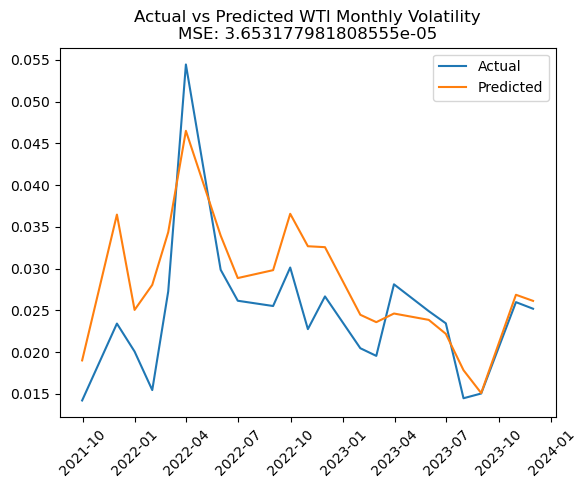

In [527]:
# Create XY df with only aligned dates
XY = pd.concat([X, Y], axis=1).dropna()

XY.describe()

# Run regression of Y on X

# Train Test Split
train_size = int(0.8 * XY.shape[0])

train = XY.iloc[:train_size, :]
test = XY.iloc[train_size:, :]
X_train = train.iloc[:, :-1]

X_train = sm.add_constant(X_train)
Y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
X_test = sm.add_constant(X_test)
Y_test = test.iloc[:, -1]

# Fit model
model = sm.OLS(Y_train, X_train)
results = model.fit()
print(results.summary())

# Predict
Y_pred = results.predict(X_test)
print('Mean Squared Error:', np.mean((Y_test - Y_pred)**2))
# Plot
plt.plot(Y_test, label='Actual')
plt.plot(Y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted WTI Monthly Volatility' + '\n' + 'MSE: ' + str(np.mean((Y_test - Y_pred)**2)))
plt.xticks(rotation=45)
plt.show()


# Model 2 (Discard Insignificant Features)

                                    OLS Regression Results                                   
Dep. Variable:     Log Geom Diff WTI Crude Oil Price   R-squared:                       0.955
Model:                                           OLS   Adj. R-squared:                  0.951
Method:                                Least Squares   F-statistic:                     270.1
Date:                               Mon, 08 Apr 2024   Prob (F-statistic):           1.39e-49
Time:                                       01:51:31   Log-Likelihood:                 327.63
No. Observations:                                 84   AIC:                            -641.3
Df Residuals:                                     77   BIC:                            -624.2
Df Model:                                          6                                         
Covariance Type:                           nonrobust                                         
                                        coef    std err     

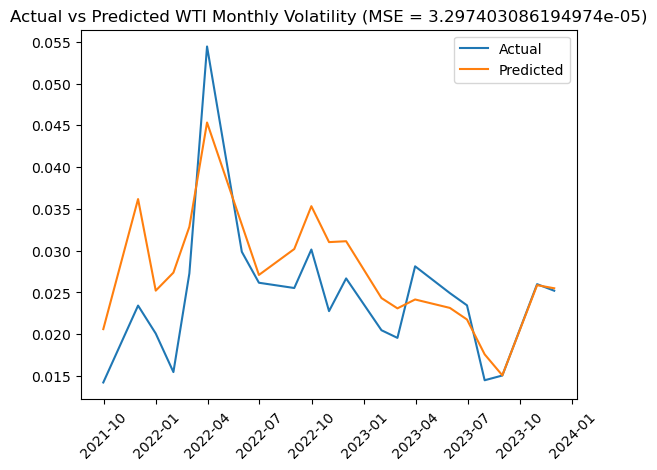

In [528]:
# Discard the following feautres:
# Crude_Oil_Production_MA               0.0015      0.003      0.565      0.574      -0.004       0.007
# Petroleum_Consumption_MA           9.944e-07   2.19e-06      0.453      0.652   -3.38e-06    5.37e-06
# Spot_Long_Contracts_Avg_Lagged       -0.0137      0.012     -1.159      0.250      -0.037       0.010
# SPY_Lagged_Vol                        0.1918      0.239      0.802      0.425      -0.285       0.669

XY.drop(['Crude_Oil_Production_MA', 'Petroleum_Consumption_MA', 'Spot_Long_Contracts_Avg_Lagged', 'SPY_Lagged_Vol'], axis=1, inplace=True)

XY.dropna()


# Train Test Split
train_size = int(0.8 * XY.shape[0])

train = XY.iloc[:train_size, :]
test = XY.iloc[train_size:, :]
X_train = train.iloc[:, :-1]
X_train = sm.add_constant(X_train)
Y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
X_test = sm.add_constant(X_test)
Y_test = test.iloc[:, -1]

# Fit model
model = sm.OLS(Y_train, X_train)
results = model.fit()
print(results.summary())

# Predict
Y_pred = results.predict(X_test)
# Plot
plt.plot(Y_test, label='Actual')
plt.plot(Y_pred, label='Predicted')
plt.title('Actual vs Predicted WTI Monthly Volatility (MSE = ' + str(np.mean((Y_test - Y_pred)**2)) + ')')
plt.xticks(rotation=45)
plt.legend()


# Model 3 (VAR)

c:\Users\nicho\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


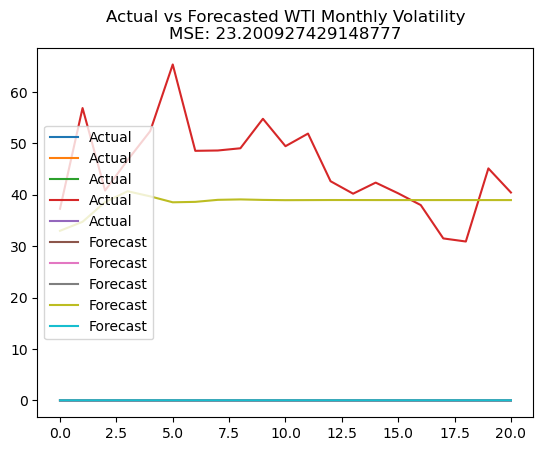

In [529]:
# Estimate VAR model on the following features + the target variable:

# Drop the following feautures:
# Spot_Next_11_Contracts_Avg_Lagged     0.0263      0.018      1.453      0.150      -0.010       0.062
# WTI_Lagged_Spot_Change                0.0075      0.006      1.354      0.180      -0.004       0.019

XY.drop(['Spot_Next_11_Contracts_Avg_Lagged', 'WTI_Lagged_Spot_Change'], axis=1, inplace=True)

XY.dropna()

# Train Test Split
train_size = int(0.8 * XY.shape[0])

train = XY.iloc[:train_size, :]
test = XY.iloc[train_size:, :]

# Fit VAR model
model = sm.tsa.VAR(train)
results = model.fit(2)
results.summary()

# Forecast
n_steps = len(test)
initial_values = train.values[-results.k_ar:]  

iterative_forecasts = []

# Iteratively forecast one step at a time
for step in range(n_steps):
    # Forecast one step
    step_forecast = results.forecast(initial_values[-results.k_ar:], steps=1)
    
    # Append forecast to iterative_forecasts
    iterative_forecasts.append(step_forecast[0])  # Capture the forecast
    
    # Update initial_values by appending the new forecast and dropping the oldest observation
    initial_values = np.vstack([initial_values, step_forecast])

# Convert iterative forecasts to a numpy array (if needed for further analysis)
iterative_forecasts = np.array(iterative_forecasts)

# Plot the iterative forecasts with MSE
plt.plot(test.values, label='Actual')
plt.plot(iterative_forecasts, label='Forecast')
plt.title('Actual vs Forecasted WTI Monthly Volatility' + '\n' + 'MSE: ' + str(np.mean((test.values - iterative_forecasts)**2)))
plt.legend()